In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

Iterations that were run: 12


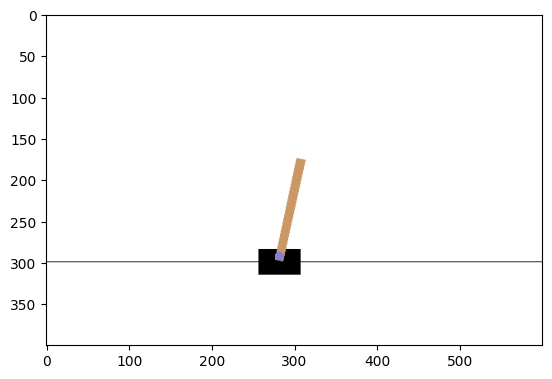

In [ ]:
env = gym.make('CartPole-v0')
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50000):
  action = env.action_space.sample()
  print("step i",i,"action=",action)
  obs, reward, done, info = env.step(action)
  print("obs=",obs,"reward=",reward,"done=",done,"info=",info)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()
print("Iterations that were run:",i)

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, alpha):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.softmax(x, dim=-1)

    def predict(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        action_probs = self.forward(state)
        return action_probs.detach().numpy()

    def gradient_log_prob(self, state, action):
        state = torch.tensor(state, dtype=torch.float32)
        action_probs = self.forward(state)
        log_prob = torch.log(action_probs[action])
        self.optimizer.zero_grad()
        log_prob.backward()
        return [param.grad for param in self.parameters()]

    def update_policy(self, grad_log_prob, G, t, gamma):
        for param, grad in zip(self.parameters(), grad_log_prob):
            param.grad = -grad * (gamma ** t) * G
        self.optimizer.step()

In [ ]:
class REINFORCE:
    def __init__(self, alpha, gamma, policy_network, num_episodes):
        self.alpha = alpha
        self.gamma = gamma
        self.policy_network = policy_network
        self.num_episodes = num_episodes

    def generate_episode(self, env):
        episode = []
        state = env.reset()
        done = False
        while not done:
            action_probs = self.policy_network.predict(state)
            action = np.random.choice(len(action_probs), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state
        return episode

    def reinforce(self, env):
        for episode in range(self.num_episodes):
            episode_data = self.generate_episode(env)

            for t in range(len(episode_data)):
                G = 0
                for k in range(t, len(episode_data)):
                    _, _, reward = episode_data[k]
                    G += (self.gamma ** (k - t)) * reward

                state, action, _ = episode_data[t]
                grad_log_prob = self.policy_network.gradient_log_prob(state, action)
                self.policy_network.update_policy(grad_log_prob, G, t, self.gamma)

            if episode % 100 == 0: print(f"Episode {episode} completed")

    def test_policy(self):
        env = gym.make("CartPole-v0", max_episode_steps=10_000)
        obs = env.reset()
        prev_screen = env.render(mode='rgb_array')
        plt.imshow(prev_screen)
        ipythondisplay.display(plt.gcf())

        for i in range(50000):
            action_probs = self.policy_network.predict(obs)
            action = np.argmax(action_probs)
            obs, reward, done, info = env.step(action)

            print(f"Step {i}: Action={action}, Obs={obs}, Reward={reward}, Done={done}, Info={info}")

            screen = env.render(mode='rgb_array')
            plt.imshow(screen)
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())

            if done:
                break

        ipythondisplay.clear_output(wait=True)
        env.close()
        print(f"Iterations that were run: {i}")

In [ ]:
# Set up the environment and hyperparameters
env = gym.make("CartPole-v0", max_episode_steps=10_000_000)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
alpha = 0.01
gamma = 0.99
num_episodes = 100_000

# Create the policy network
policy_network = PolicyNetwork(state_dim, action_dim, alpha)

# Create and run the REINFORCE algorithm
reinforce_agent = REINFORCE(alpha, gamma, policy_network, num_episodes)
reinforce_agent.reinforce(env)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 0 completed
Episode 100 completed
Episode 200 completed
Episode 300 completed
Episode 400 completed
Episode 500 completed
Episode 600 completed
Episode 700 completed
Episode 800 completed
Episode 900 completed
Episode 1000 completed
Episode 1100 completed
Episode 1200 completed
Episode 1300 completed
Episode 1400 completed
Episode 1500 completed
Episode 1600 completed
Episode 1700 completed
Episode 1800 completed
Episode 1900 completed
Episode 2000 completed
Episode 2100 completed
Episode 2200 completed
Episode 2300 completed
Episode 2400 completed
Episode 2500 completed
Episode 2600 completed
Episode 2700 completed
Episode 2800 completed
Episode 2900 completed
Episode 3000 completed
Episode 3100 completed
Episode 3200 completed
Episode 3300 completed
Episode 3400 completed
Episode 3500 completed
Episode 3600 completed
Episode 3700 completed
Episode 3800 completed
Episode 3900 completed
Episode 4000 completed
Episode 4100 completed
Episode 4200 completed
Episode 4300 completed


Iterations that were run: 9


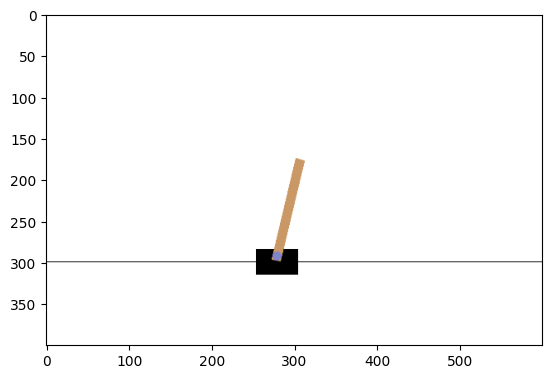

In [ ]:
# Test the trained policy
reinforce_agent.test_policy()